In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import re
import PIL
import shutil
tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

# Problem Statement

Generative deep learning is a subfield of machine learning that focuses on building models that can generate new data that is similar to the input data. These models are typically based on deep neural networks, which are composed of multiple layers of interconnected nodes that can learn complex patterns in the data. There are several types of deep learning models used in generative deep learning, including: Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), and Recurrent Neural Networks (RNNs). 

GANs consist of two neural networks that are trained in a competitive game-like manner, with one network generating new data and the other network trying to distinguish between real and generated data. The key idea behind GANs is that they learn to capture the underlying distribution of the input data, and can then generate new, realistic-looking data samples that have similar statistical properties to the original data. This makes them useful for a wide range of applications, such as image and video synthesis, text generation, and even music and sound synthesis.GANs have become increasingly popular in recent years due to their ability to generate high-quality, realistic images and other types of data.

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). The aim of this mini-project is to build a specific GAN (Cycle Consistant Adversarial Network(CycleGan)) to generate 7,000 to 10,000 Monet-style images.


# Reference
This mini-project is heavily inspired by some notebooks liste below. I've learnt a lot from their excellent work.
- https://www.unite.ai/what-is-a-generative-adversarial-network-gan/
- https://github.com/kech3776/Monet-CycleGan/blob/main/Monet%20Gan.ipynb
- https://en.wikipedia.org/wiki/Generative_adversarial_network
- https://www.kaggle.com/competitions/gan-getting-started/overview
- https://keras.io/examples/generative/cyclegan/#building-blocks-used-in-the-cyclegan-generators-and-discriminators
- https://github.com/andersy005/ms-ds-notebooks/blob/main/cu-dtsa-5511/gan-getting-started.ipynb


# Data

- The dataset consists of 2 types of images
  - 300 real Monet paintings
- 7000 photos that we are to convert to a style of a Monet painting
- Each image is of 256 x 256 pixels with Red, Green & Blue chanels

In [2]:
root_dir = os.path.expanduser('/kaggle/input/gan-getting-started')
monet_files = tf.io.gfile.glob(str(f'{root_dir}/monet_tfrec/monet*.tfrec'))
photo_files = tf.io.gfile.glob(str(f'{root_dir}/photo_tfrec/photo*.tfrec'))

len(monet_files), len(photo_files)

(5, 20)

Get the number of examples in each dataset.

In [3]:
n_monet_samples = sum(int(re.compile(r"-([0-9]*)\.").search(filename)[1]) for filename in monet_files)
n_photo_samples = sum(int(re.compile(r"-([0-9]*)\.").search(filename)[1]) for filename in photo_files)
n_monet_samples, n_photo_samples

(300, 7038)

# Exploratory Data Analysis

In [4]:
# set seed for experiment reproducibility
tf.random.set_seed(2023)
np.random.seed(2023)

# some helper functions

batch_size = 1
orig_img_size = (256, 256)
input_img_size = (256, 256, 3)
buffer_size = 256

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img

def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

def read_tfrecord(item):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    item = tf.io.parse_single_example(item, features)
    image = tf.image.decode_jpeg(item['image'], channels=3)
    image = tf.cast(image, tf.float32)
    # normalize the pixel values to [-1, 1]
    image = (image / 127.5) - 1
    return tf.reshape(image, [256, 256, 3])

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=autotune)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

monet_ds = load_dataset(monet_files)
photo_ds = load_dataset(photo_files)

In [5]:
train_size = 0.7

monet_train_size = int(n_monet_samples * train_size)
monet_test_size = n_monet_samples - monet_train_size
photo_train_size = int(n_photo_samples * train_size)
photo_test_size = n_photo_samples - photo_train_size

batch_size = 1

monet_ds = monet_ds.shuffle(1000)
photo_ds = photo_ds.shuffle(1000)

monet_train = monet_ds.take(monet_train_size).batch(batch_size)
monet_test = monet_ds.skip(monet_train_size).take(monet_test_size).batch(batch_size)

photo_train = photo_ds.take(photo_train_size).batch(batch_size)
photo_test = photo_ds.skip(photo_train_size).take(photo_test_size).batch(batch_size)


Let's first look at some examples from the 300 images with an impressionist style of Monet. 

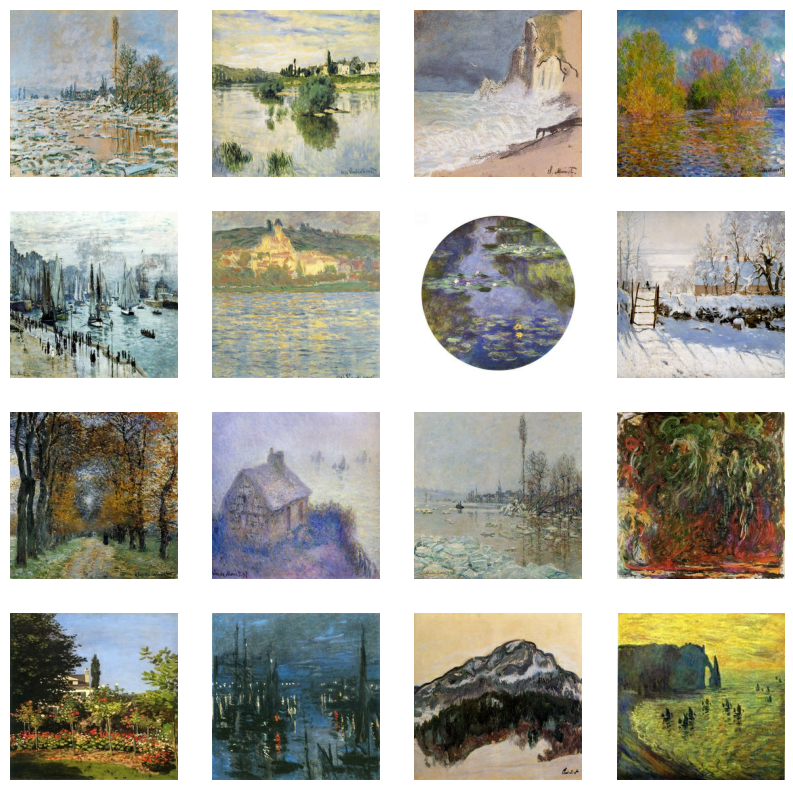

In [6]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(monet_train.take(16)):
    img = tf.squeeze(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((img + 1) / 2)
    plt.axis("off")

Here are some  examples from the 7038 real photos. 

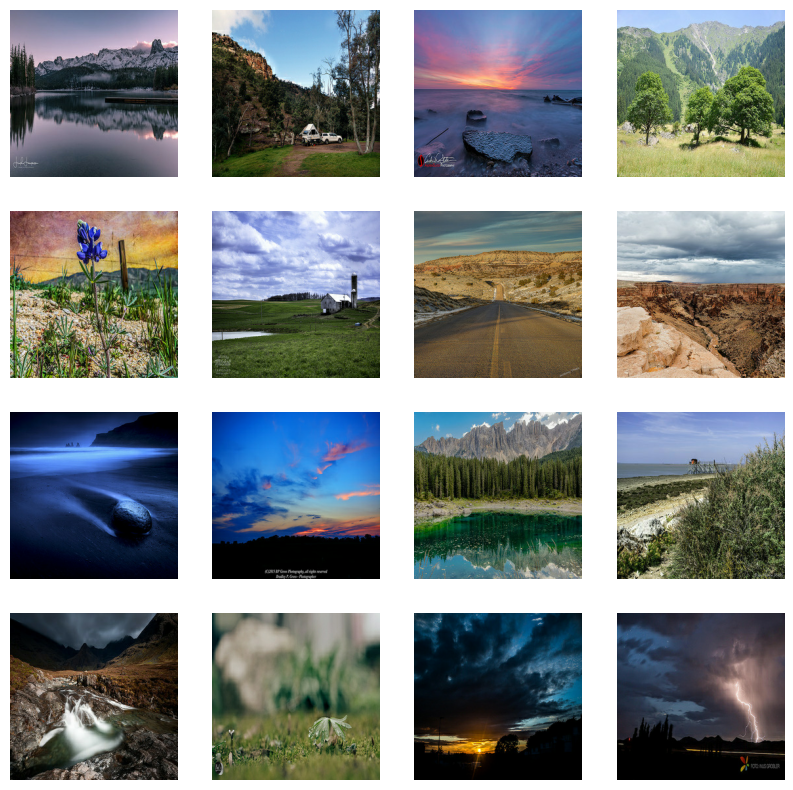

In [7]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(photo_train.take(16)):
    img = tf.squeeze(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow((img + 1) / 2)
    plt.axis("off")

## Model Architecture (CycleGAN)
As mentioned earlier, the CycleGAN model consists of two generators and two discriminators. 

The generators are responsible for generating new data, while the discriminators are responsible for distinguishing between real and generated data.

In [8]:
# reference: https://keras.io/examples/generative/cyclegan/#building-blocks-used-in-the-cyclegan-generators-and-discriminators
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [[0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

The process of downsampling involves the generator taking an image and decreasing the model size. During this downsampling, a convolutional2D layer and a normalization layer are applied to extract the essential features of the image while minimizing the need to train on numerous data points.

In [9]:
kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42)
gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42)

def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='valid',
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = tf.keras.layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = tf.keras.layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = tf.keras.layers.Add()([input_tensor, x])
    return x

In [10]:
def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding='same',
    gamma_initializer=gamma_init,
):
    x = tf.keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)

    return x

def upsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding='same',
    gamma_initializer=gamma_init,
):
    x = tf.keras.layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)

    if activation:
        x = activation(x)

    return x

After the downsampling, a residual block helps improve information propagation through the network, ultimately improving the quality of the generated images.

### Generator
The generator has the following steps:
- Imports and normalizes an image 
- Downsamples the image into a smaller tensor
- Transforms the tensor with residual blocks
- Upsamples the tensor back into an image

It has 2 downsampling blocks, 8 residual blocks, and 2 upsampling blocks with a convolutional 2D layer at the end.

In [11]:
def resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = tf.keras.layers.Input(shape=[256, 256, 3], name=f'{name}_img_input')

    x = ReflectionPadding2D((3, 3))(img_input)
    x = tf.keras.layers.Conv2D(filters, (7, 7), padding='valid', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x,
            filters=filters,
            activation=tf.keras.layers.Activation('relu'),
            gamma_initializer=gamma_initializer)

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=tf.keras.layers.Activation('relu'), gamma_initializer=gamma_initializer)

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x,
            filters=filters,
            activation=tf.keras.layers.Activation('relu'),
            gamma_initializer=gamma_initializer)

    x = ReflectionPadding2D((3, 3))(x)
    x = tf.keras.layers.Conv2D(3, (7, 7), padding='valid')(x)
    x = tf.keras.layers.Activation('tanh')(x)

    return tf.keras.models.Model(img_input, x, name=name)

### Discriminator
The discriminator takes in an image and decideds if it is real or not. It has an input layer, 3 downsampling layers, and a convolutional2D layer. It then return the loss values.

In [12]:
def discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None):
    img_input = tf.keras.layers.Input(shape=[256, 256, 3], name=f'{name}_img_input')

    x = img_input

    x = tf.keras.layers.Conv2D(
        filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer
    )(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        strides = (1, 1) if num_downsample_block < 2 else (2, 2)
        x = tf.keras.layers.Conv2D(
            num_filters,
            (4, 4),
            strides=strides,
            padding='same',
            kernel_initializer=kernel_initializer,
            use_bias=False,
        )(x)
        x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding='same', kernel_initializer=kernel_initializer
    )(x)

    return tf.keras.models.Model(img_input, x, name=name)

## Result and Analysis

In [13]:
# Get the generators
gen_G = resnet_generator(name='gen_G')
gen_F = resnet_generator(name='gen_F')

# Get the discriminators
disc_X = discriminator(name='disc_X')
disc_Y = discriminator(name='disc_Y')

In [14]:
# visualize the structure
gen_G.summary()

Model: "gen_G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gen_G_img_input (InputLayer)   [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reflection_padding2d (Reflecti  (None, 262, 262, 3)  0          ['gen_G_img_input[0][0]']        
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['reflection_padding2d[0][0]']   
                                )                                                             

## Build CycleGAN class
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

In [15]:

class CycleGan(tf.keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn

        self.cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = tf.keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is photo and y is monet
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:

            # Generator G translates X -> Y
            # Generator F translates Y -> X.

            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            # Cycle
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_real_y = self.disc_Y(real_y, training=True)

            disc_fake_x = self.disc_X(fake_x, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y) * self.lambda_cycle * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x) * self.lambda_cycle * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Calculate the gradients for generator and discriminator
        generator_G_gradients = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        generator_F_gradients = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        discriminator_X_gradients = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        discriminator_Y_gradients = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Apply the gradients to the optimizer
        self.gen_G_optimizer.apply_gradients(
            zip(generator_G_gradients, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(generator_F_gradients, self.gen_F.trainable_variables)
        )

        self.disc_X_optimizer.apply_gradients(
            zip(discriminator_X_gradients, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(discriminator_Y_gradients, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [16]:
# callback to save image
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_train.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
        plt.show()
        plt.close()

## Train the end-to-end model

In [17]:
# loss function for evaluating adversarial loss
adv_loss_fn = tf.keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    return adv_loss_fn(tf.ones_like(fake), fake)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) / 2

## Create CycleGAN model
CycleGAN is a deep learning technique for unsupervised image-to-image translation, i.e., it can learn to translate images from one domain to another without the need for paired training data.

Epoch 1/5
    210/Unknown - 256s 866ms/step - G_loss: 5.1580 - F_loss: 5.7455 - D_X_loss: 0.1006 - D_Y_loss: 0.1217

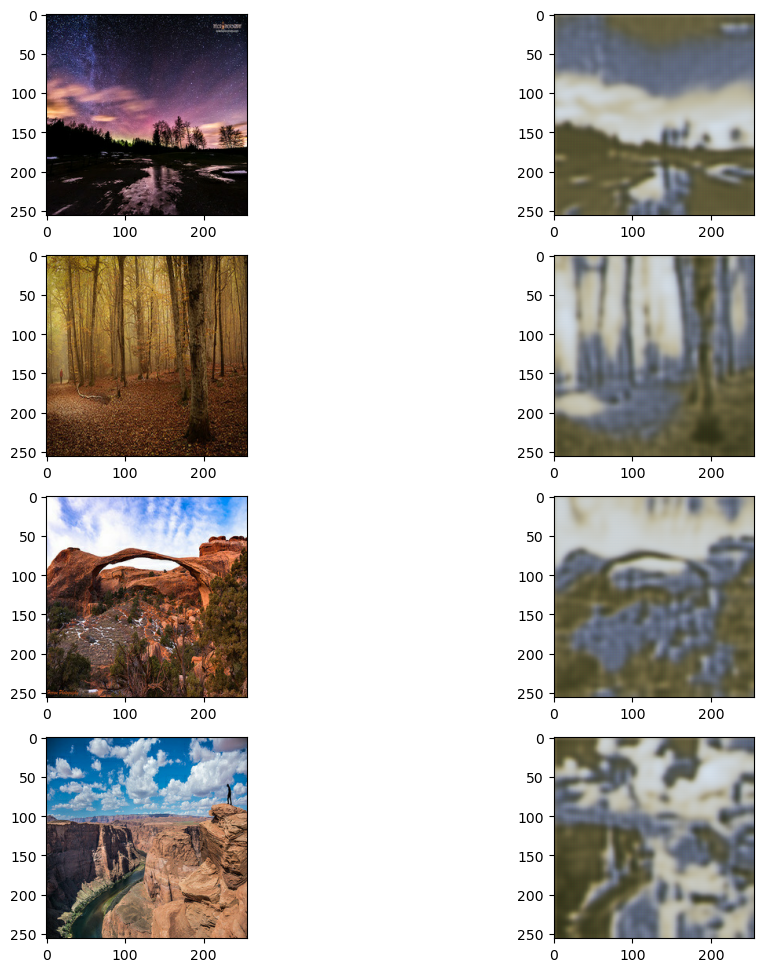

210/210 [==============================] - 258s 880ms/step - G_loss: 5.1505 - F_loss: 5.7643 - D_X_loss: 0.1004 - D_Y_loss: 0.1224
Epoch 2/5
210/210 [==============================] - ETA: 0s - G_loss: 4.7768 - F_loss: 5.2161 - D_X_loss: 0.1058 - D_Y_loss: 0.1360

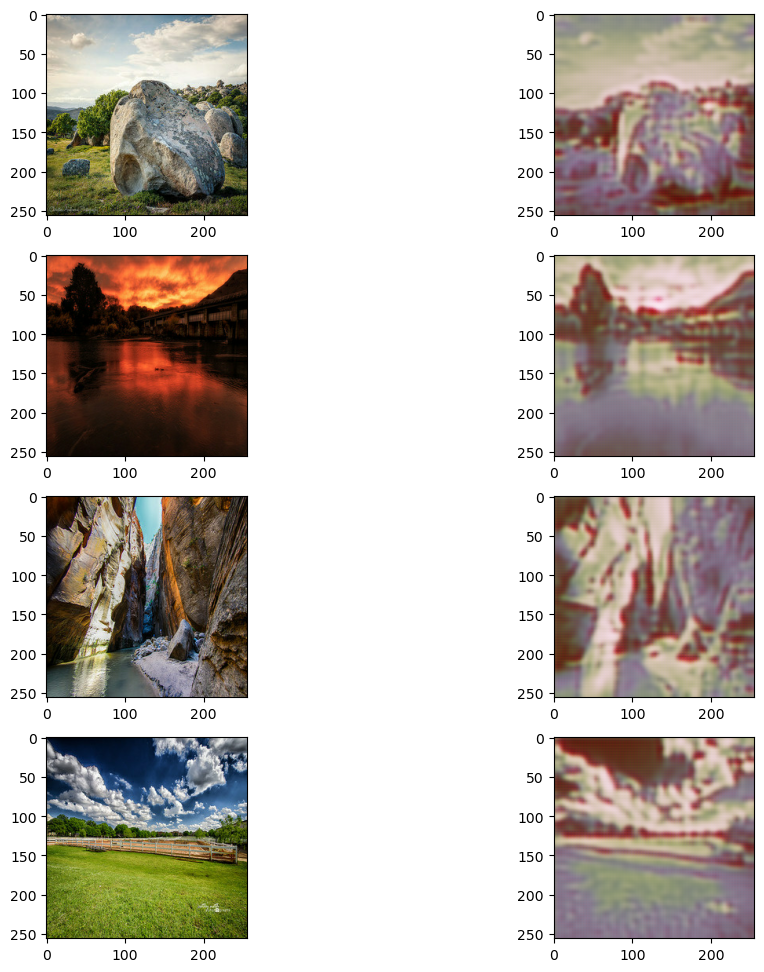

210/210 [==============================] - 189s 892ms/step - G_loss: 4.7734 - F_loss: 5.2109 - D_X_loss: 0.1058 - D_Y_loss: 0.1355
Epoch 3/5
210/210 [==============================] - ETA: 0s - G_loss: 4.8140 - F_loss: 4.9635 - D_X_loss: 0.1444 - D_Y_loss: 0.1613

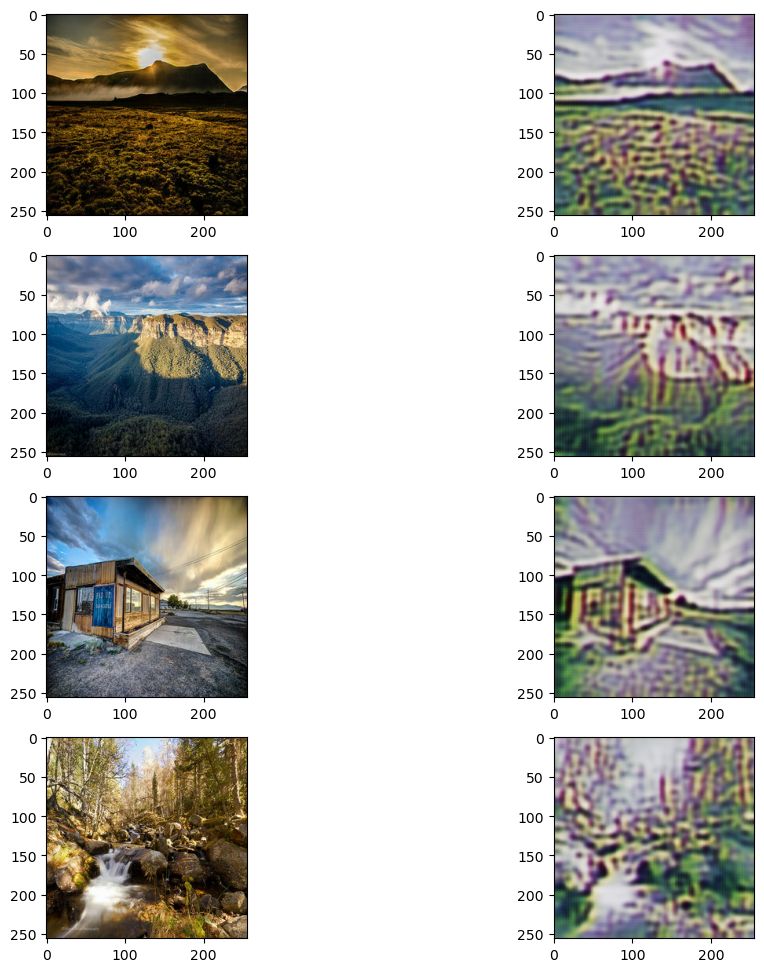

210/210 [==============================] - 189s 891ms/step - G_loss: 4.8253 - F_loss: 4.9568 - D_X_loss: 0.1444 - D_Y_loss: 0.1609
Epoch 4/5
210/210 [==============================] - ETA: 0s - G_loss: 4.7473 - F_loss: 4.9546 - D_X_loss: 0.1016 - D_Y_loss: 0.1330

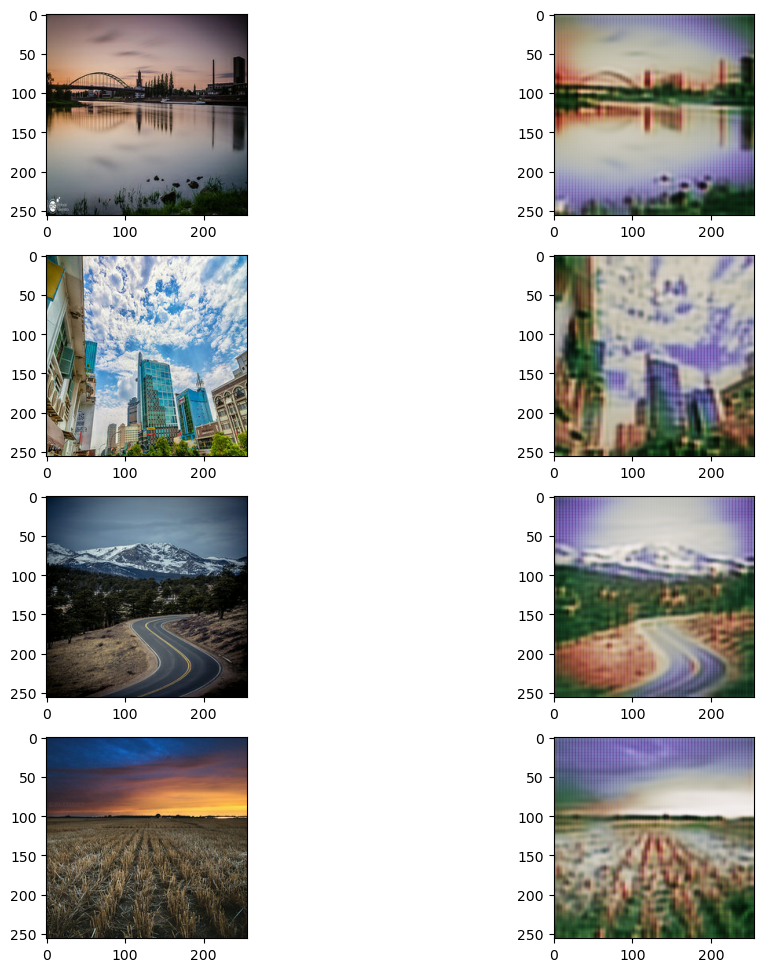

210/210 [==============================] - 188s 887ms/step - G_loss: 4.7445 - F_loss: 4.9561 - D_X_loss: 0.1012 - D_Y_loss: 0.1333
Epoch 5/5
210/210 [==============================] - ETA: 0s - G_loss: 4.4084 - F_loss: 4.9170 - D_X_loss: 0.1005 - D_Y_loss: 0.1741

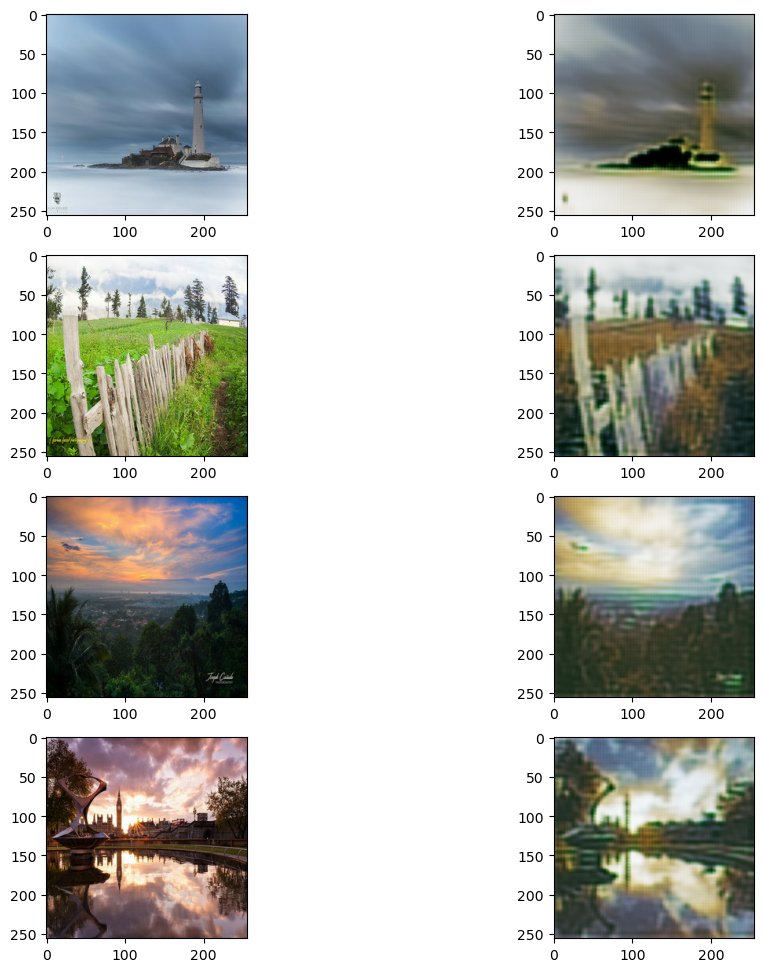

210/210 [==============================] - 187s 886ms/step - G_loss: 4.4181 - F_loss: 4.9107 - D_X_loss: 0.1006 - D_Y_loss: 0.1736


In [18]:
cycle_gan_model = CycleGan(
    generator_G=gen_G,
    generator_F=gen_F,
    discriminator_X=disc_X,
    discriminator_Y=disc_Y,
)
# compile
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# Callback to save images
plotter = GANMonitor()

checkpoint_path = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train, monet_train)),
    epochs=5,
    callbacks=[plotter],
)

After the model was trained, we could made comparisons between some of the photo images and the generated images from the Monet generator. We can see that the generated images bear a close resemblance to Monet-style images. To get this result, several hyperparameters were adjusted, e.g., the filters in the upsampling and downsampling, the learning rate, the number of residual blocks, and the epochs. I found that reducing the number of filters and increasing the number of epochs helped to maintain a lower generator error after tuning.

In [19]:
epoch = 5
epoch_lst = list(range(1, epoch + 1))

generator_loss = pd.DataFrame(list(zip(epoch_lst, history.history['G_loss'],
                        history.history['F_loss'])),
                        columns = ['Epoch','G_loss', 'F_loss'])
discriminator_loss = pd.DataFrame(list(zip(epoch_lst, history.history['D_X_loss'],
                        history.history['D_Y_loss'])),
                        columns = ['Epoch','D_X_loss', 'D_Y_loss'])

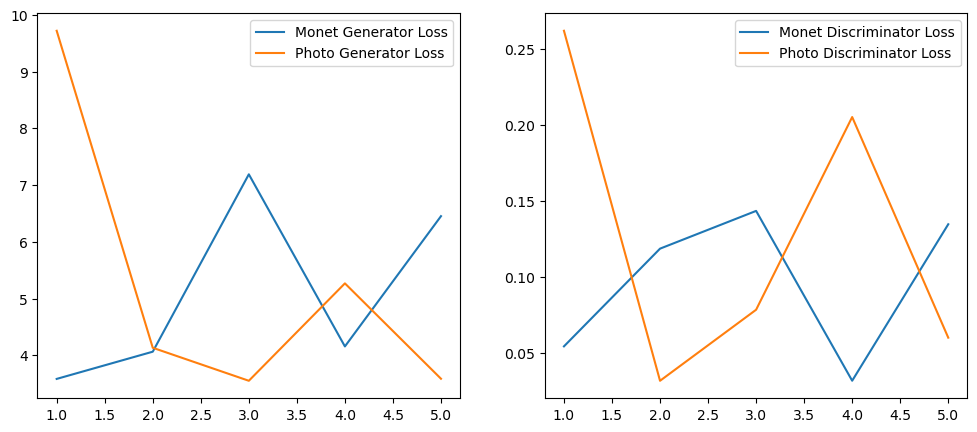

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(generator_loss['Epoch'],generator_loss['G_loss'])
ax1.plot(generator_loss['Epoch'],generator_loss['F_loss'])
ax1.legend(['Monet Generator Loss', 'Photo Generator Loss'])

ax2.plot(discriminator_loss['Epoch'], discriminator_loss['D_X_loss'])
ax2.plot(discriminator_loss['Epoch'], discriminator_loss['D_Y_loss'])
ax2.legend(['Monet Discriminator Loss', 'Photo Discriminator Loss'])

# Conclusion & Discussion

- This is a great learning experience. With the help of a lot of turorials, I was able to have a basic understanding about GAN and create and train the CycleGAN model to transfer the Monet-style to a real image. The model is far from perfect, as we can see the model added or removed details in images in unpredictable ways.
- Keep the learning rate low helped reduce overfitting and make the performance more stable. 
- As we can see from the results, if we further increase the number of epochs for training (e.g., 10, 15, 20), the perfromance is likely to be improved. 
- The dataset is relatvely small. Data augmentation might be helpful to provide more diverse images for the model to learn and improve the accuracy.

# Submission

In [21]:
!mkdir -p /kaggle/images

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [22]:
index = 0

for index, img in enumerate(photo_ds.batch(1)):
    prediction = gen_G(img, training=False).numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    for pred in prediction:
        im = PIL.Image.fromarray(pred)
        im.save(f"/kaggle/images/{index}.jpg")
        index += 1
print(index)

7038


In [23]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'